<a id="title_ID"></a>
# Intermediate: Finding Flares and Variable Stars in TASOC Light Curves

This notebook demostrates MAST's programmatic tools for accessing TESS time series data while exploring a flaring star from the literature ([G&uuml;nther et al 2019](https://arxiv.org/abs/1901.00443)) and a nearby variable star.  

The following topics will be covered:
- Using the MAST API to get mission pipeline and TASOC light curves
- Plotting TESS light curves in Python
- Using the MAST API to make an full frame image (FFI) cutout
- Creating a movie of TPF frames in Python
- Using the MAST API to get a list of TESS Input Catalog (TIC) sources
- Over plotting TIC sources on TESS images
- Exploring the period of a variable star

### Table of contents

1. [Exploring a known stellar flare](#Exploring-a-stellar-flare) 
    1. [Querying MAST](#Querying-MAST)
    2. [Downloading the light curves](#Downloading-the-light-curves)
    3. [Plotting the light curves](#Plotting-the-light-curves)
    4. [Making an animation](#Making-an-animation)
2. [Exploring a variable star](#Exploring-a-variable-star) 
    1. [Overlaying TESS Input Catalog sources](#Overlaying-TIC-sources)
    2. [Getting the variable star light curve](#Getting-the-variable-star-light-curve)
    3. [Plotting the variable star light curve](#Plotting-the-variable-star-light-curve)
    4. [Finding the period of the variable star](#Finding-the-period)
4. [Additional Resources](#Additional-Resources)  
5. [About this Notebook](#About-this-Notebook) 

***

## Terminology

- **TESS:** The Transiting Exoplanet Survey Satellite
- **TASOC:** The TESS Asteroseismic Science Operations Center
- **Sector:** TESS observed the sky in regions of 24x96 degrees along the southern, then northern, ecliptic hemispheres. Each of these regions is referred to as a "sector", starting with Sector 1.
- **TIC:** The TESS input catalog.
- **FFI:** TESS periodically reads out the entire frame of all four cameras, nominally every 30 minutes, and stores them as full frame images (FFIs).
- **TPF:** Target Pixel File, a fits file containing stacks of small images centered on a target, one image for every timestamp the telescope took data.
- **HDU:** Header Data Unit. A FITS file is made up of HDUs that contain data and metadata relating to the file. The first HDU is called the primary HDU, and anything that follows is considered an "extension", e.g., "the first FITS extension", "the second FITS extension", etc.
- **HDUList:** A list of HDUs that comprise a fits file.
- **BJD:** Barycentric Julian Date, the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System center of mass.
- **BTJD:** Barycentric TESS Julian Date, the timestamp measured in BJD, but offset by 2457000.0. I.e., BTJD = BJD - 2457000.0
- **WCS:** World Coordinate System, the coordinates that locate an astronomical object on the sky. 

***

## Imports

In this notbook we will use the MAST module of Astroquery (`astroquery.mast`) to query and download data, and various `astropy` and `numpy` functions to manipulate the data. We will use both the `matplotlib` and `bokeh` plotting packages to visualize our data as they have different strengths and weaknesses.

In [1]:
# For querying for data
from astroquery.mast import Tesscut, Observations, Catalogs

# For manipulating data
import numpy as np

from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.timeseries import LombScargle
import astropy.units as u

# For matplotlib plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# For animation display
from matplotlib import rc

rc("animation", html="jshtml")

# For bokeh plotting
from bokeh import plotting
from bokeh.models import Span

plotting.output_notebook()

Loading BokehJS ...

***

## Exploring a stellar flare

### Selecting the flare

We will start with a known flare from the literature, in this case from [G&uuml;nther, M. N., Zhan, Z., Seager, S.,
et al. 2019, arXiv e-prints, arXiv:1901.00443](https://arxiv.org/abs/1901.00443). We picked a particularly long flare to give us the best chance of finding it in the 30 minute cadence data as well as the 2 minute cadence data.

We've made note of the TIC ID and sector for our flare of interest, as well as its peak time in BJD format:

In [2]:
tic_id = 141914082
sector = 1

tpeak = 2458341.89227  # Julian Day

### Querying MAST

#### Mission light curves

Using the `query_criteria` function in the `astroquery.mast.Observations` class, we will specify that we are looking for TESS mission data using the `obs_collection` argument, that we want a specific TIC ID using the `target_name` argument, and that we want observations from a particular sector using the `sequence_number` argument.

In [3]:
mission_res = Observations.query_criteria(
    obs_collection="TESS", target_name=tic_id, sequence_number=sector
)
mission_res

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str4,str10,str4,str4,str7,str9,str1,str47,float64,float64,str10,str14,int64,float64,float64,float64,float64,float64,str1,float64,str23,str1,int64,str41,str1,str73,str6,bool,float64,str8,str9
science,TESS,SPOC,Photometer,TESS,TESS,Optical,141914082,--,tess2018206045859-s0001-0000000141914082-0120-s,94.6175354047675,-72.0448462219924,timeseries,"Ricker, George",3,58324.79323696759,58352.67632608796,120.0,600.0,1000.0,--,58458.5833333,G011175_G011180_G011176,--,1,CIRCLE 94.6175354 -72.04484622 0.00138889,--,mast:TESS/product/tess2018206045859-s0001-0000000141914082-0120-s_lc.fits,PUBLIC,False,nan,60829534,110344410


#### TASOC light curves

In addition to mission pipeline data, MAST also hosts a variety of community contributed High Level Science Products (HLSPs), all of which are given the mission (`obs_collection`) "HLSP". In this case we will specifically search for HLSPs in the TESS project, which will return the light curves provided by the TASOC (note the `provenance_name` of "TASOC"). All other arguments remain the same.

In [4]:
tasoc_res = Observations.query_criteria(
    target_name=tic_id,
    obs_collection="HLSP",
    project="TESS",
    provenance_name="TASOC",
    sequence_number=sector,
)
tasoc_res[
    "dataproduct_type",
    "obs_collection",
    "target_name",
    "t_exptime",
    "filters",
    "provenance_name",
    "project",
    "sequence_number",
    "instrument_name",
]

dataproduct_type,obs_collection,target_name,t_exptime,filters,provenance_name,project,sequence_number,instrument_name
str10,str4,str9,float64,str4,str5,str4,int64,str10
timeseries,HLSP,141914082,120.0,TESS,TASOC,TESS,1,Photometer
timeseries,HLSP,141914082,1800.0,TESS,TASOC,TESS,1,Photometer


This query returns two light curves. To understand the difference between the two light curves we look at the `t_exptime` column, and note the different values. These exposure times correspond to 2 minutes (short cadence) and 30 minutes (long cadence). We will explore both light curves.

### Downloading the light curves

For the rest of this notebook we will work with the TASOC light curves only, although we could do the same analysis on the mission light curves.

#### Querying for the list of associated data products

Each observation may have one or more associated data products. In the case of the TASOC light curves, there is simply a single light curve file for each observation. 

In [5]:
tasoc_prod = Observations.get_product_list(tasoc_res)
tasoc_prod["dataproduct_type", "description", "dataURI", "size"]

dataproduct_type,description,dataURI,size
str10,str4,str125,int64
timeseries,FITS,mast:HLSP/tasoc/s0001/c0120/0000/0001/4191/4082/hlsp_tasoc_tess_tpf_tic00141914082-s0001-cam4-ccd2-c0120_tess_v05_cbv-lc.fits,1880640
timeseries,FITS,mast:HLSP/tasoc/s0001/c1800/0000/0001/4191/4082/hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05_cbv-lc.fits,164160
timeseries,FITS,mast:HLSP/tasoc/s0001/c1800/0000/0001/4191/4082/hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05_ens-lc.fits,167040


In [6]:
tasoc_prod

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str8,str4,str10,str65,str4,str1,str125,str7,str28,str1,str1,str5,str1,str23,str77,int64,str8,str6,int64,str4
79352767,HLSP,timeseries,hlsp_tasoc_tess_tpf_tic00141914082-s0001-cam4-ccd2-c0120_tess_v05,FITS,C,mast:HLSP/tasoc/s0001/c0120/0000/0001/4191/4082/hlsp_tasoc_tess_tpf_tic00141914082-s0001-cam4-ccd2-c0120_tess_v05_cbv-lc.fits,SCIENCE,Minimum Recommended Products,--,--,TASOC,5,G011160_G011155_G011188,hlsp_tasoc_tess_tpf_tic00141914082-s0001-cam4-ccd2-c0120_tess_v05_cbv-lc.fits,1880640,79352767,PUBLIC,4,TESS
79500562,HLSP,timeseries,hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05,FITS,C,mast:HLSP/tasoc/s0001/c1800/0000/0001/4191/4082/hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05_cbv-lc.fits,SCIENCE,Minimum Recommended Products,--,--,TASOC,5,G011160_G011155_G011188,hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05_cbv-lc.fits,164160,79500562,PUBLIC,4,TESS
79500562,HLSP,timeseries,hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05,FITS,C,mast:HLSP/tasoc/s0001/c1800/0000/0001/4191/4082/hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05_ens-lc.fits,SCIENCE,Minimum Recommended Products,--,--,TASOC,5,G011160_G011155_G011188,hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05_ens-lc.fits,167040,79500562,PUBLIC,4,TESS


#### Downloading files

We can choose to download some or all of the associated data files, in this case since we just have the two light curves, we will download all of the products.

In [7]:
tasoc_manifest = Observations.download_products(tasoc_prod)
tasoc_manifest

INFO: Found cached file ./mastDownload/HLSP/hlsp_tasoc_tess_tpf_tic00141914082-s0001-cam4-ccd2-c0120_tess_v05/hlsp_tasoc_tess_tpf_tic00141914082-s0001-cam4-ccd2-c0120_tess_v05_cbv-lc.fits with expected size 1880640. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05/hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05_cbv-lc.fits with expected size 164160. [astroquery.query]


INFO: Found cached file ./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05/hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05_ens-lc.fits with expected size 167040. [astroquery.query]


Local Path,Status,Message,URL
str163,str8,object,object
./mastDownload/HLSP/hlsp_tasoc_tess_tpf_tic00141914082-s0001-cam4-ccd2-c0120_tess_v05/hlsp_tasoc_tess_tpf_tic00141914082-s0001-cam4-ccd2-c0120_tess_v05_cbv-lc.fits,COMPLETE,None,None
./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05/hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05_cbv-lc.fits,COMPLETE,None,None
./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05/hlsp_tasoc_tess_ffi_tic00141914082-s0001-cam4-ccd2-c1800_tess_v05_ens-lc.fits,COMPLETE,None,None


### Plotting the light curves

We will use the `bokeh` plotting library so that we can have interactivity, and will plot both the 2 minute and 30 minute cadence data together. 

We can tell which file corresponds to which cadence length by examining the filenames and noting that one contains `c0120` (2 minutes) and the other `c1800` (30 minutes).

In [8]:
# Loading the short cadence light curve
hdu = fits.open(tasoc_manifest["Local Path"][0])
short_cad_lc = Table(hdu[1].data)
hdu.close()

# Loading the long cadence light curve
hdu = fits.open(tasoc_manifest["Local Path"][1])
long_cad_lc = Table(hdu[1].data)
hdu.close()

In [9]:
short_cad_lc

TIME,TIMECORR,CADENCENO,FLUX_RAW,FLUX_RAW_ERR,FLUX_BKG,FLUX_CORR,FLUX_CORR_ERR,QUALITY,PIXEL_QUALITY,MOM_CENTR1,MOM_CENTR2,POS_CORR1,POS_CORR2
float64,float32,int32,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64
1325.2947319105515,0.00039239877,70444,58018.69140625,27.071533203125,5857.234375,nan,nan,1,8,834.4894913456625,1609.6587898246,nan,nan
1325.2961207871213,0.00039238695,70445,58050.12109375,27.080039978027344,5833.82373046875,-15477.966097362183,459.27373681573056,0,0,834.430622215893,1609.5960119991153,0.0649784728884697,-0.03711783513426781
1325.2975096636906,0.00039237514,70446,57973.33984375,27.066831588745117,5845.93603515625,-16172.59679890426,459.3333885300957,0,0,834.4032677520236,1609.5634975061746,0.036016035825014114,-0.07080704718828201
1325.298898540259,0.00039236332,70447,58019.12109375,27.08187484741211,5858.75341796875,-14821.928321840816,459.85648759641083,0,0,834.402491815588,1609.5602055022941,0.03578070178627968,-0.0754164531826973
1325.3002874168287,0.0003923515,70448,58076.87890625,27.095388412475586,5857.07421875,-13300.352272517579,460.33827411396686,0,0,834.4016689968498,1609.5490218886023,0.03445006534457207,-0.08668677508831024
1325.3016762934271,0.00039233972,70449,58152.546875,27.10507583618164,5852.03125,-11505.904315655347,460.7400512437479,0,0,834.3952826332988,1609.5489387485015,0.027773790061473846,-0.0863100215792656
1325.3030651700246,0.00039232793,70450,58128.62890625,27.102537155151367,5861.92041015625,-11435.558188753192,460.9192581793382,0,0,834.3942480477758,1609.5484839779504,0.026579076424241066,-0.08645732700824738
1325.3044540466235,0.00039231614,70451,58119.8046875,27.1026554107666,5862.89794921875,-11139.658936588527,461.129234988274,0,0,834.3987730048251,1609.5451413977958,0.030768081545829773,-0.09115128219127655
1325.305842923251,0.00039230438,70452,58085.265625,27.096769332885742,5874.02685546875,-11311.563370110078,461.22303515680187,0,0,834.396795392446,1609.5473010803428,0.029517315328121185,-0.0876065194606781


In [10]:
long_cad_lc.columns

<TableColumns names=('TIME','TIMECORR','CADENCENO','FLUX_RAW','FLUX_RAW_ERR','FLUX_BKG','FLUX_CORR','FLUX_CORR_ERR','QUALITY','PIXEL_QUALITY','MOM_CENTR1','MOM_CENTR2','POS_CORR1','POS_CORR2')>

In [11]:
bfig = plotting.figure(
    width=850, height=300, title=f"Detrended Lightcurve (TIC{tic_id})"
)

# Short cadence
bfig.scatter(
    short_cad_lc["TIME"],
    short_cad_lc["FLUX_RAW"] / np.median(short_cad_lc["FLUX_RAW"]),
    fill_color="black",
    size=2,
    line_color=None,
)
bfig.line(
    short_cad_lc["TIME"],
    short_cad_lc["FLUX_RAW"] / np.median(short_cad_lc["FLUX_RAW"]),
    line_color="black",
)

# Long cadence
bfig.scatter(
    long_cad_lc["TIME"],
    long_cad_lc["FLUX_RAW"],
    fill_color="#0384f7",
    size=6,
    line_color=None,
)
bfig.line(long_cad_lc["TIME"], long_cad_lc["FLUX_RAW"], line_color="#0384f7")

# Marking the flare (tpeak is in BJD, while the time column in the light curve is BTJD, so we must convert)
vline = Span(
    location=(tpeak - 2457000), dimension="height", line_color="#bf006e", line_width=3
)
bfig.renderers.extend([vline])

# Labeling the axes
bfig.xaxis.axis_label = "Time (BTJD)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

Experiment with the controls on the right to zoom in and and pan around on this light curve to look at the marked flare and other features (some sort of periodic feature maybe?)

### Making an animation

Looking at the above plot we can see the flare event in both the long and short cadence light curves. Since we can see it even in the 30 minute data, we should be able to make an animation of the area around the flaring star and see the flare happen. In order to do this, we'll need a way to get all of the images for this target. For our object of interest, we could use the pre-existing target pixel files (TPFs); however, many interesting targets do not have TPFs from TESS. Instead, we'll use TESScut, the MAST cutout tool for full-frame images to cutout the area around the flaring star across the entire sector, and then make a movie that shows how it changes over time.

There is a TESScut API: the `astroquery.mast` __[Tesscut](https://astroquery.readthedocs.io/en/latest/mast/mast.html#tesscut)__ class, which we can use to make this cutout.  Specifically, we can call the `Tesscut.get_cutouts` function.

In [12]:
cutout_hdu = Tesscut.get_cutouts(objectname=f"TIC {tic_id}", size=40, sector=1)[0]

This query will return a list of `HDUList` objects, each of which is the cutout target pixel file (TPF) for a single sector. In this case, because we specified a single sector we know that the resulting list will only have one element and can pull it out directly.

In [13]:
cutout_hdu.info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  PIXELS        1 BinTableHDU    281   1282R x 12C   [D, E, J, 1600J, 1600E, 1600E, 1600E, 1600E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        82   (40, 40)   int32   


A TESScut TPF has three extensions:
- No. 0 (Primary): This HDU contains meta-data related to the entire file.
- No. 1 (Pixels): This HDU contains a binary table that holds data like cutout image arrays and times. We will extract information from here to get our set of cutout images.
- No. 2 (Aperture): This HDU contains the image extension with data collected from the aperture. We will use this extension to get the WCS associated with out cutout.


In [14]:
cutout_table = Table(cutout_hdu[1].data)
cutout_table.columns

<TableColumns names=('TIME','TIMECORR','CADENCENO','RAW_CNTS','FLUX','FLUX_ERR','FLUX_BKG','FLUX_BKG_ERR','QUALITY','POS_CORR1','POS_CORR2','FFI_FILE')>

The Pixels extension contains the cutout data table, which has a number of columns. For our puposes we care about the "TIME" column which has the observation times in BTJD, and the "FLUX" column which contains the cutout images (they  are calibrated, but not background subtracted).

#### Exploring the cutout time series

We want to explore what is happening within our cutout area over the time that the flare occurs, so we will make an animated plot of the cutout frames.

We can't make a movie of the whole sector (it would take too long), so we will choose only the time range around the flare.

Use the light curve plot to figure out what time range you want to animate, or use our selections.

In [15]:
start_btjd = 1341.5
end_btjd = 1342.5

start_index = (np.abs(cutout_table["TIME"] - start_btjd)).argmin()
end_index = (np.abs(cutout_table["TIME"] - end_btjd)).argmin()

print(f"Frames {start_index}-{end_index} ({end_index-start_index} frames)")

Frames 721-769 (48 frames)


#### Looking at the animated cutout

In [16]:
def make_animation(
    data_array, start_frame=0, end_frame=None, vmin=None, vmax=None, delay=50
):
    """
    Function that takes an array where each frame is a 2D image array and make an animated plot
    that runs through the frames.

    Note: This can take a long time to run if you have a lot of frames.
    Parameters
    ----------
    data_array : array
        Array of 2D images.
    start_frame : int
        The index of the initial frame to show. Default is the first frame.
    end_frame : int
        The index of the final frame to show. Default is the last frame.
    vmin : float
        Data range min for the colormap. Defaults to data minimum value.
    vmax : float
        Data range max for the colormap. Defaults to data maximum value.
    delay:
        Delay before the next frame is shown in milliseconds.

    Returns
    -------
    response : `animation.FuncAnimation`
    """

    if not vmin:
        vmin = np.min(data_array)
    if not vmax:
        vmax = np.max(data_array)

    if not end_frame:
        end_frame = len(data_array) - 1  # set to the end of the array

    num_frames = end_frame - start_frame + 1  # include the end frame

    def animate(i, fig, ax, binarytab, start=0):
        """Function used to update the animation"""
        ax.set_title("Epoch #" + str(i + start))
        im = ax.imshow(binarytab[i + start], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)
        return (im,)

    # Create initial plot.
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(data_array[start_frame], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)

    ani = animation.FuncAnimation(
        fig,
        animate,
        fargs=(fig, ax, data_array, start_frame),
        frames=num_frames,
        interval=delay,
        repeat_delay=1000,
    )

    plt.close()

    return ani

In [17]:
make_animation(cutout_table["FLUX"], start_index, end_index, vmax=700, delay=150)

We can see three things in this plot:
- The flare that occures in frames 740-743
- An aberration that appears in frame 754
- A variable star pulsing in the lower right corner

***

## Exploring a variable star

Now we will look more closely at the variable star we can see in the animation. We will use the TESS Input Catalog (TIC) to figure out the TESS ID of the variable star, and then using that ID pull down and explore the star's light curve from MAST. 

### Overlaying TIC sources

First we will use the `astroquery.mast.Catalog` class to query the TESS Input Catalog (TIC) and get a list of sources that appear in our cutout.

Here we do a simple cone search and the apply a magnitude limit. Play around with the magnitude limit to see how it changes the number of sources.

In [18]:
sources = Catalogs.query_object(
    catalog="TIC", objectname=f"TIC {tic_id}", radius=10 * u.arcmin
)
sources = sources[sources["Tmag"] < 12]
print(f"Number of sources: {len(sources)}")
print(sources)

Number of sources: 9
    ID           ra               dec        ... wdflag     dstArcSec     
--------- ---------------- ----------------- ... ------ ------------------
141914082 94.6175354047675 -72.0448462219924 ...      0                0.0
141914038 94.7353652417206 -72.0837957851839 ...      0   191.637404585262
141914103 94.7749592275334 -72.0227841314024 ...      0 192.00656069294254
141914130 94.5074642175418  -71.998930582098 ...      0  205.6248622381558
141914317 94.9032150266819 -72.0334742503164 ...      0   319.770063872556
141913994 94.5588022852622 -72.1321979465057 ...      0 321.11922083466345
166975135 94.6067354129356 -71.9255734581109 ...      0 429.55027273236567
141869504 94.2183733431791 -72.0232095513896 ...      0  450.0317520158321
141913929 94.7099836100023 -72.1924762405753 ...      0  541.2030879067767


#### Plotting sources on an individual cutout

We will get the WCS infomation associated with our cutout from the Aperture extension, and use it to make a WCS-aware plot of a single cutout image. Then we display the image and sources together, and label the sources with their row number in the catalog table.

In [19]:
cutout_wcs = WCS(cutout_hdu[2].header)
cutout_img = cutout_table["FLUX"][start_index]

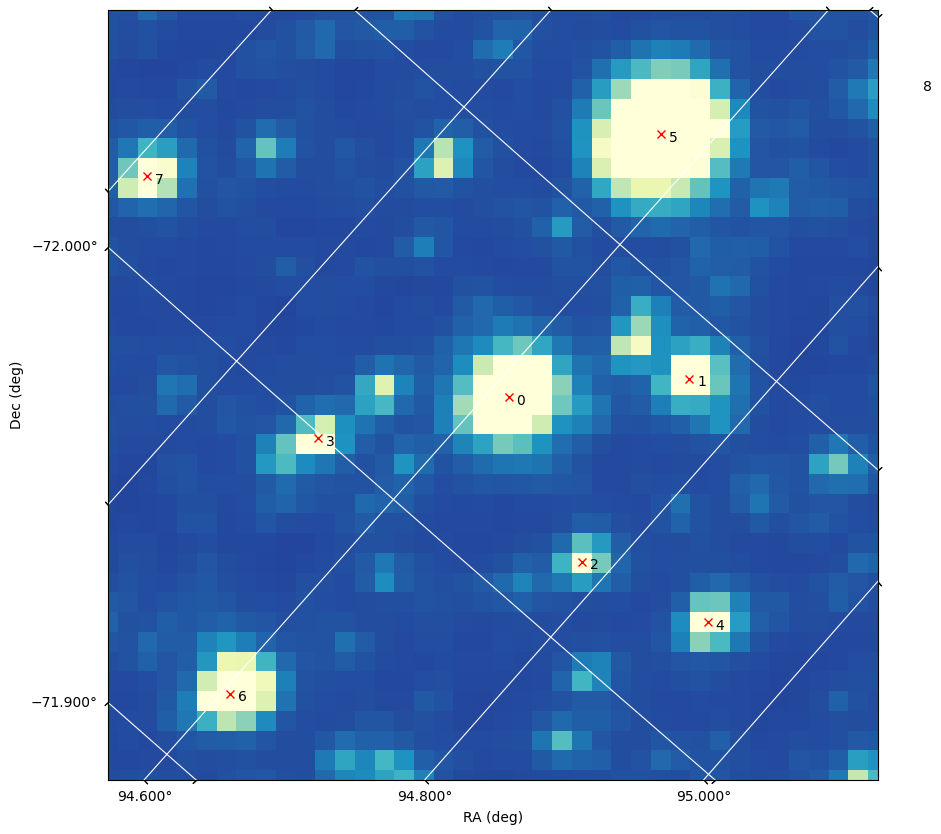

In [20]:
fig, ax = plt.subplots(subplot_kw={"projection": cutout_wcs})
fig.set_size_inches(10, 10)
plt.grid(color="white", ls="solid")

# Setup WCS axes.
xcoords = ax.coords[0]
ycoords = ax.coords[1]
xcoords.set_major_formatter("d.ddd")
ycoords.set_major_formatter("d.ddd")
xcoords.set_axislabel("RA (deg)")
ycoords.set_axislabel("Dec (deg)")
ax.imshow(cutout_img, cmap=plt.cm.YlGnBu_r, vmin=0, vmax=700)
ax.plot(
    sources["ra"], sources["dec"], "x", transform=ax.get_transform("icrs"), color="red"
)

# Annotating the sources with their row nnumber in the sources table
for i, star in enumerate(sources):
    ax.text(star["ra"] + 0.01, star["dec"], i, transform=ax.get_transform("icrs"))

ax.set_xlim(0, cutout_img.shape[1] - 1)
ax.set_ylim(cutout_img.shape[0] - 1, 0)

plt.show()

The variable star is row 4 in the catalog sources table (note that if you changed the magnitude threshold the variale star may be in a different row).

In [21]:
sources["ID", "ra", "dec"][4]

ID,ra,dec
str11,float64,float64
141914317,94.9032150266819,-72.0334742503164


### Getting the variable star light curve

Again, we will look specifically for the TASOC light curve(s) associated with this star, rather than the mission pipeline ones. Below we go through the same process as in the [Downloading the light curves](#Downloading-the-light-curves) section to search for the observation, then find the associated data products, and download them.

In [22]:
variable_tic_id = sources["ID"][4]

variable_res = Observations.query_criteria(
    target_name=str(variable_tic_id), obs_collection="HLSP", filters="TESS"
)

print(f"Number of tasoc light curves for {variable_tic_id}: {len(variable_res)}\n")


variable_prod = Observations.get_product_list(variable_res[0])
variable_manifest = Observations.download_products(variable_prod)

Number of tasoc light curves for 141914317: 102

INFO: Found cached file ./mastDownload/HLSP/hlsp_qlp_tess_ffi_s0013-0000000141914317_tess_v01_llc/hlsp_qlp_tess_ffi_s0013-0000000141914317_tess_v01_llc.fits with expected size 83520. [astroquery.query]


INFO: Found cached file ./mastDownload/HLSP/hlsp_qlp_tess_ffi_s0013-0000000141914317_tess_v01_llc/hlsp_qlp_tess_ffi_s0013-0000000141914317_tess_v01_llc.txt with expected size 64163. [astroquery.query]


Note that this time there is only one (30 minute cadence) TASOC light curve. This is because this star was not one of the targets that TESS observed at the shorter cadence.

In [23]:
hdu = fits.open(variable_manifest["Local Path"][0])
variable_lc = Table(hdu[1].data)
hdu.close()

### Plotting the variable star light curve

We will again plot the light curve using bokeh so that we have interactivity.

In [24]:
variable_lc

TIME,CADENCENO,SAP_FLUX,KSPSAP_FLUX,KSPSAP_FLUX_ERR,QUALITY,ORBITID,SAP_X,SAP_Y,SAP_BKG,SAP_BKG_ERR,KSPSAP_FLUX_SML,KSPSAP_FLUX_LAG
float64,int32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32
1653.9281264088759,20470,1.0268497,1.0558715,0.13665526,4128,33,421.72015,1216.5792,55.87,303.0,1.0491947,1.0580579
1653.948959649118,20471,0.9360396,0.9612099,0.13665526,4096,33,421.72424,1216.5784,63.58,413.66,0.96619904,0.95966774
1653.969792891784,20472,0.8209844,0.8419681,0.13665526,4096,33,421.73187,1216.5752,-218.77,387.51,0.86041814,0.83654326
1653.9906261366607,20473,0.7616569,0.7801408,0.13665526,4096,33,421.735,1216.5725,-0.87,454.05,0.80635834,0.7720926
1654.011459383893,20474,0.8281789,0.8472413,0.13665526,4096,33,421.73022,1216.5757,-157.54,447.66,0.8650209,0.84183574
1654.0322926332728,20475,0.94315326,0.96371984,0.13665526,4096,33,421.7236,1216.5797,84.09,448.03,0.96824825,0.96247375
1654.053125884903,20476,1.0280553,1.0492675,0.13665526,4096,33,421.71915,1216.5809,-48.59,350.11,1.0434113,1.0512749
1654.0739591385864,20477,1.0823321,1.1034349,0.13665526,4096,33,421.71863,1216.5817,-22.17,435.48,1.0914406,1.1074061
1654.0947923943963,20478,1.105596,1.1259379,0.13665526,4096,33,421.7166,1216.583,42.58,475.55,1.1116827,1.1304736


In [25]:
bfig = plotting.figure(
    width=850, height=300, title=f"Detrended Lightcurve (TIC{variable_tic_id})"
)

bfig.scatter(
    variable_lc["TIME"],
    variable_lc["SAP_FLUX"],
    fill_color="black",
    size=4,
    line_color=None,
)
bfig.line(variable_lc["TIME"], variable_lc["SAP_FLUX"], line_color="black")

# Labeling the axes
bfig.xaxis.axis_label = "Time (BTJD)"
bfig.yaxis.axis_label = "SAP Flux"

plotting.show(bfig)

That looks variable all right!

### Finding the period

We'll run a Lomb Scargle priodogram on this light curve to see if we can quantify the periodic behavior. To do this we will use the `astropy.timeseries` class [LombScargle](https://docs.astropy.org/en/stable/timeseries/lombscargle.html).

In [26]:
lomb = LombScargle(variable_lc["TIME"], variable_lc["SAP_FLUX"])
frequency, power = lomb.autopower(maximum_frequency=25)

#### Plotting the periodogram

In [27]:
bfig = plotting.figure(
    width=850, height=300, x_range=(0, 25), title=f"Periodogram (TIC{variable_tic_id})"
)

bfig.line(frequency, power, line_color="black")

# Labeling the axes
bfig.xaxis.axis_label = "Frequency (1/day)"
bfig.yaxis.axis_label = "Power"

plotting.show(bfig)

#### Phasing on the highest power period/frequency

There is a clear dominant frequency in the above plot, with a small harmonic also visible. We will phase the stellar light curve on the period corresponding to the dominant frequency and plot both it and the corresponding sinusoidal fit.

In [28]:
dominant_freq = frequency[np.argmax(power)].value
print(f"The dominant period: {1/dominant_freq*24:.3} hours")

The dominant period: 5.24 hours


In [29]:
bfig = plotting.figure(
    width=850, height=300, title=f"Phased Lightcurve (TIC{variable_tic_id})"
)

# Plotting the phased light curve
bfig.scatter(
    variable_lc["TIME"] % (1 / dominant_freq),
    variable_lc["SAP_FLUX"],
    fill_color="black",
    size=4,
    line_color=None,
)

# Plotting the periodic fit
t_fit = np.linspace(0, 1 / dominant_freq, 100)
bfig.line(t_fit, lomb.model(t_fit, dominant_freq), color="#1b9f00", line_width=2)

# Labeling the axes
bfig.xaxis.axis_label = "Phase (days)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

***

## Additional Resources

- [Main TESS page at MAST](https://archive.stsci.edu/tess)
- [MAST Astroquery documentation](https://astroquery.readthedocs.io/en/latest/mast/mast.html)

## About this Notebook
**Author:** C. E. Brasseur, STScI Software Engineer

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 